In [1]:
import os
import numpy as np
import random as r
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from CalcMFCC import calculate_mfcc
import InitialParams as ip
import PinkNoise as pn

In [2]:
def pad_or_truncate_mfcc(mfcc, max_length):
    current_length = mfcc.shape[0]
    if current_length < max_length:
        padding = max_length - current_length
        return np.pad(mfcc, ((0, padding), (0, 0)), mode='constant')
    else:
        return mfcc[:max_length]

def normalize_features(X):
    scaler = StandardScaler()
    X_reshaped = X.reshape(-1, X.shape[-1])
    X_normalized = scaler.fit_transform(X_reshaped).reshape(X.shape)
    return X_normalized, scaler

def prepare_data(audio_files, sample_rate, win_len, hop_len, n_mfcc, max_length, noised=False, intensity = 0.0001):
    mfcc_features = []
    labels = []
    SNR = 0
    label_map = {label: idx for idx, label in enumerate(audio_files.keys())}
    for label, files in audio_files.items():
        for file in files:
            audio = librosa.load(file, sr=sample_rate)[0]
            if noised == True:
                pink_noise = pn.generate_pink_noise(len(audio)) 
                pink_audio = pn.generate_noisy_signal(audio, pink_noise, intensity)
                SNR = 10*np.log(np.sum(np.power(audio, 2))/np.sum(np.power(pink_audio-audio, 2)))
                audio = pink_audio
            mfcc = calculate_mfcc(audio, sample_rate, win_len, hop_len, n_mfcc)
            mfcc = pad_or_truncate_mfcc(mfcc.T, max_length)
            mfcc_features.append(mfcc)
            labels.append(label_map[label])
    
    X = np.array(mfcc_features)
    y = np.array(labels)
    X, scaler = normalize_features(X)
    
    return X, y, scaler, SNR

In [3]:
np.random.seed(42)
r.seed(42)
tf.random.set_seed(42)

In [4]:
Soileushiler = {}
for i in range(1, 17):
    Soileushiler[i-1] = [f'DaustarNew/Soyleushy_{i}/' + j for j in os.listdir(f'DaustarNew/Soyleushy_{i}')]

print(f'''Дискреттеу жиілігі: {ip.F_dis} Гц,
MFCC коэффициенттер саны: {ip.n_mfcc},
MFCC фреймінің ұзындығы: {ip.mfcc_frame}''')

X, y, scaler, _ = prepare_data(Soileushiler, ip.F_dis, ip.win_len, ip.hop_len, ip.n_mfcc, ip.mfcc_frame)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

Дискреттеу жиілігі: 48000 Гц,
MFCC коэффициенттер саны: 20,
MFCC фреймінің ұзындығы: 170


In [124]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_model():
    temp_model = Sequential([
        Masking(mask_value=0.0, input_shape=(ip.mfcc_frame, ip.n_mfcc)),
        Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling1D(pool_size=2),
        Conv1D(256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(16, activation='softmax') 
    ])
    temp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return temp_model


CNNmodel = create_model()
CNNmodel.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_27 (Masking)        (None, 170, 20)           0         
                                                                 
 conv1d_54 (Conv1D)          (None, 168, 128)          7808      
                                                                 
 max_pooling1d_54 (MaxPooli  (None, 84, 128)           0         
 ng1D)                                                           
                                                                 
 conv1d_55 (Conv1D)          (None, 82, 256)           98560     
                                                                 
 max_pooling1d_55 (MaxPooli  (None, 41, 256)           0         
 ng1D)                                                           
                                                                 
 flatten_27 (Flatten)        (None, 10496)           

In [6]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
]

In [125]:
history = CNNmodel.fit(X_train,
                       y_train, epochs=100, batch_size=64, validation_split=0.1,
                       callbacks=callbacks)

Epoch 1/100
3/3 [==============================] - 1s 158ms/step - loss: 7.7524 - accuracy: 0.0779 - val_loss: 7.0242 - val_accuracy: 0.1111 - lr: 0.0010
Epoch 2/100
3/3 [==============================] - 0s 87ms/step - loss: 6.6966 - accuracy: 0.2468 - val_loss: 6.3692 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/100
3/3 [==============================] - 0s 76ms/step - loss: 5.9020 - accuracy: 0.5260 - val_loss: 5.9360 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/100
3/3 [==============================] - 0s 81ms/step - loss: 5.2552 - accuracy: 0.6169 - val_loss: 5.2407 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/100
3/3 [==============================] - 0s 87ms/step - loss: 4.6147 - accuracy: 0.7273 - val_loss: 4.7687 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 6/100
3/3 [==============================] - 0s 69ms/step - loss: 4.1513 - accuracy: 0.8117 - val_loss: 4.2511 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 7/100
3/3 [==============================] - 0s 69ms/step - loss: 3.9096 - 

In [126]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

epoch_count = np.array(range(1, 91))
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = go.Figure()
fig.add_trace(go.Scatter(x=epoch_count, y=accuracy, mode='lines+markers', name='Оқыту дәлдігі'))
fig.add_trace(go.Scatter(x=epoch_count, y=val_accuracy, mode='lines+markers', name='Валидация дәлдігі'))
fig.update_layout(title='Эпоха сайын Оқыту және Валидация кезіндегі дәлдік', xaxis_title='Эпоха саны', yaxis_title='Дәлдік')
fig.show()

In [127]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=epoch_count, y=loss, mode='lines+markers', name='Оқыту жоғалтулары'))
fig.add_trace(go.Scatter(x=epoch_count, y=val_loss, mode='lines+markers', name='Валидациялық жоғалтулар'))
fig.update_layout(title='Эпоха сайын Оқыту және Валидация кезіндегі жоғалтулар', xaxis_title='Эпоха саны', yaxis_title='Жоғалтулар')
fig.show()

In [128]:
import numpy as np

test_loss, test_accuracy = CNNmodel.evaluate(X_test, y_test)
print(f'Тестілік жоғалтулар: {test_loss:.4f}')
print(f'Тестілік дәлдік: {test_accuracy:.4f}')


1/1 [==============================] - 0s 40ms/step - loss: 0.7126 - accuracy: 0.9500
Тестілік жоғалтулар: 0.7126
Тестілік дәлдік: 0.9500


In [129]:
import plotly.express as px
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y_pred_probabilities = CNNmodel.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=[i for i in range(0, 16)])

xlabels = [f'Сөйлеуші_{i+1}' for i in range(0, 16)]

fig = px.imshow(conf_matrix, x=xlabels, y=xlabels, text_auto='.d', aspect='auto', color_continuous_scale='Greens',\
               labels=dict(x='Болжанған белгілер', y='Рас белгілеря'))
fig.update_layout(title='Олқылық матрицасы')
fig.show()


1/1 [==============================] - 0s 86ms/step


C:\Users\Администратор\Desktop\DiplomPython\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Администратор\Desktop\DiplomPython\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Администратор\Desktop\DiplomPython\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<Axes: >

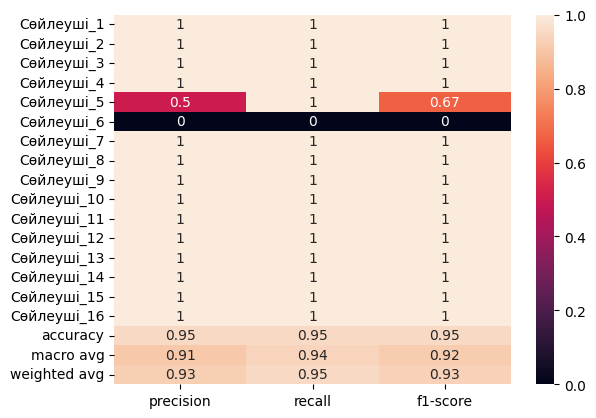

In [130]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report


class_report = classification_report(y_test, y_pred, labels=[i for i in range(0, 16)],
                                   target_names=[f'Сөйлеуші_{i+1}' for i in range(0, 16)],
                                   output_dict=True)
sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, annot=True)

In [146]:
CNNmodel.save('speaker_verification_model_cnn.keras')

import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [147]:
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

In [131]:
FP = np.sum(conf_matrix, axis=0) - np.diag(conf_matrix)
FN = np.sum(conf_matrix, axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)

FAR = FP / (FP + TN)
FRR = FN / (FN + TP)

print(f'Орташа FAR: {FAR.mean()}')
print(f'Орташа FRR: {FRR.mean()}')

Орташа FAR: 0.003289473684210526
Орташа FRR: 0.0625


In [148]:
intensity = 0.01
X_noise, y_noise, scaler_noise, SNR = prepare_data(Soileushiler, ip.F_dis, ip.win_len, ip.hop_len, ip.n_mfcc, ip.mfcc_frame, noised=True, intensity=intensity)
X_noise_train, X_noise_test, y_noise_train, y_noise_test = train_test_split(X_noise, y_noise, test_size=0.1, stratify=y, random_state=42)
print(f"SNR, шу интенсивтілігі {intensity} = {SNR}")

SNR, шу интенсивтілігі 0.01 = 43.608311136340305


In [135]:
test_loss_noise, test_accuracy_noise = CNNmodel.evaluate(X_noise_test, y_test)
print(f'Тестілік жоғалтулар (шу бар сигнал): {test_loss_noise}')
print(f'Тестілік дәлдік (шу бар сигнал): {test_accuracy_noise}')

y_pred_noisy = np.argmax(CNNmodel.predict(X_noise_test), axis=1)

all_labels = list(range(16))

conf_matrix_noisy = confusion_matrix(y_test, y_pred_noisy, labels=all_labels)




xlabels = [f'Сөйлеуші_{i+1}' for i in range(0, 16)]

fig = px.imshow(conf_matrix_noisy, x=xlabels, y=xlabels, text_auto='.d', aspect='auto', color_continuous_scale='Greens',\
               labels=dict(x='Болжанған белгілер', y='Рас белгілер'))
fig.update_layout(title='Шу бар мәліметке тестіленген олқылық матрицасы')
fig.show()

1/1 [==============================] - 0s 35ms/step - loss: 1.3474 - accuracy: 0.8500
Тестілік жоғалтулар (шу бар сигнал): 1.3474453687667847
Тестілік дәлдік (шу бар сигнал): 0.8500000238418579
1/1 [==============================] - 0s 18ms/step


C:\Users\Администратор\Desktop\DiplomPython\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Администратор\Desktop\DiplomPython\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Администратор\Desktop\DiplomPython\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<Axes: >

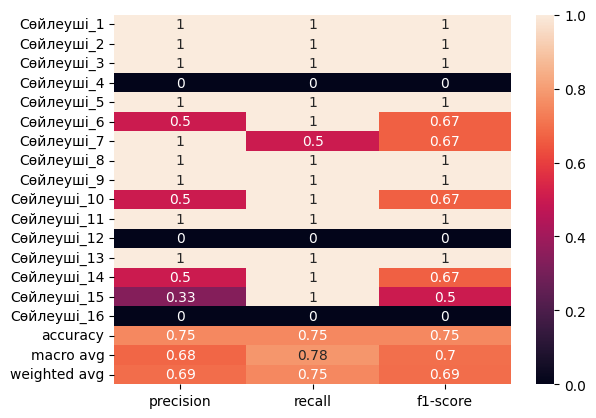

In [144]:
class_report_noisy = classification_report(y_test, y_pred_noisy, labels=all_labels, target_names=[f'Сөйлеуші_{i+1}' for i in all_labels], output_dict=True)
sns.heatmap(pd.DataFrame(class_report_noisy).iloc[:-1, :].T, annot=True)

In [145]:
FP_noise = np.sum(conf_matrix_noisy, axis=0) - np.diag(conf_matrix_noisy)
FN_noise = np.sum(conf_matrix_noisy, axis=1) - np.diag(conf_matrix_noisy)
TP_noise = np.diag(conf_matrix_noisy)
TN_noise = conf_matrix_noisy.sum() - (FP_noise + FN_noise + TP_noise)

FAR_noise = FP_noise / (FP_noise + TN_noise)
FRR_noise = FN_noise / (FN_noise + TP_noise)

print(f'Шу бар мәліметтің орташа FAR: {FAR_noise.mean()}')
print(f'Шу бар мәліметтің орташа FRR: {FRR_noise.mean()}')

Шу бар мәліметтің орташа FAR: 0.01644736842105263
Шу бар мәліметтің орташа FRR: 0.21875
